In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [41]:
def trender_bloomberg_style(df, period=14, sensitivity=1, use_close=True):

    df = df.copy()
    df.sort_index(inplace=True)  # no extra "NaT" from mis-sorted index
    


    close_prev = df['Close'].shift(1)
    tr = pd.DataFrame({
        'range1': df['High'] - df['Low'],
        'range2': (df['High'] - close_prev).abs(),
        'range3': (df['Low']  - close_prev).abs()
    }).max(axis=1)

    mp = 0.5 * (df['High'] + df['Low'])

    ema_mp = mp.ewm(span=period, adjust=False).mean()
    ema_tr = tr.ewm(span=period, adjust=False).mean()


    sd_ema_tr = ema_tr.rolling(window=period).std()

    up_base   = ema_mp - 0.5 * ema_tr - sensitivity * sd_ema_tr
    down_base = ema_mp + 0.5 * ema_tr + sensitivity * sd_ema_tr

    n = len(df)
    trender_up = np.full(n, np.nan)
    trender_down = np.full(n, np.nan)
    trend = np.full(n, 0)  # +1 for uptrend, -1 for downtrend

    first_valid = sd_ema_tr.first_valid_index()
    if first_valid is None:
        return pd.DataFrame({
            'TrenderUp': trender_up,
            'TrenderDown': trender_down,
            'Trend': trend
        }, index=df.index)

    start_i = df.index.get_loc(first_valid)


    price_series = df['Close'] if use_close else df['High']
    if price_series.iloc[start_i] > up_base.iloc[start_i]:
        trend[start_i] = +1
        trender_up[start_i] = up_base.iloc[start_i]
    else:
        trend[start_i] = -1
        trender_down[start_i] = down_base.iloc[start_i]

    for i in range(start_i + 1, n):
        if trend[i-1] == +1:
            trender_up[i] = max(up_base.iloc[i], trender_up[i-1])
            if price_series.iloc[i] < trender_up[i]:
                trend[i] = -1
                trender_down[i] = down_base.iloc[i]
            else:
                trend[i] = +1

        else:

            prev_down = trender_down[i-1] if not np.isnan(trender_down[i-1]) else down_base.iloc[i-1]
            trender_down[i] = min(down_base.iloc[i], prev_down)
            if price_series.iloc[i] > trender_down[i]:
                trend[i] = +1
                trender_up[i] = up_base.iloc[i]
            else:
                trend[i] = -1

    for i in range(n):
        if trend[i] == +1:
            trender_down[i] = np.nan
        else:
            trender_up[i] = np.nan

    result = pd.DataFrame({
        'TrenderUp': trender_up,
        'TrenderDown': trender_down,
        'Trend': trend
    }, index=df.index)

    return result


In [47]:
def ewm_std(series, span):
    ewm_mean   = series.ewm(span=span, adjust=False).mean()
    ewm_meansq = (series**2).ewm(span=span, adjust=False).mean()
    return np.sqrt(ewm_meansq - ewm_mean**2)

def trender_bloomberg_style(df, period=14, sensitivity=1, use_close=True):

    df = df.copy()
    df.sort_index(inplace=True)

    high = df['High']
    low  = df['Low']
    close = df['Close']

    prev_close = close.shift(1)
    tr = pd.DataFrame({
        'r1': high - low,
        'r2': (high - prev_close).abs(),
        'r3': (low  - prev_close).abs()
    }).max(axis=1)

    mp = 0.5*(high + low)

    ema_mp = mp.ewm(span=period, adjust=False).mean()
    ema_tr = tr.ewm(span=period, adjust=False).mean()

    sd_ema_tr = ewm_std(ema_tr, period)

    up_base   = ema_mp - 0.5*ema_tr - sensitivity*sd_ema_tr
    down_base = ema_mp + 0.5*ema_tr + sensitivity*sd_ema_tr

    n = len(df)
    up_line   = np.full(n, np.nan)
    down_line = np.full(n, np.nan)
    trend     = np.full(n, 0, dtype=int)

    # pick an initial day where stdev is not NaN
    first_valid = sd_ema_tr.first_valid_index()
    if first_valid is None:
        return pd.DataFrame(
            {'TrenderUp': up_line, 'TrenderDown': down_line, 'Trend': trend},
            index=df.index
        )
    start_i = df.index.get_loc(first_valid)

    # initial condition
    # e.g. if close > up_base => uptrend
    price_series = close if use_close else high
    if price_series.iloc[start_i] > up_base.iloc[start_i]:
        trend[start_i] = +1
        up_line[start_i] = up_base.iloc[start_i]
    else:
        trend[start_i] = -1
        down_line[start_i] = down_base.iloc[start_i]


    for i in range(start_i, n-1):
        if trend[i] == +1:

            if i > start_i:
                up_line[i] = max(up_base[i], up_line[i-1])
            if price_series.iloc[i] < up_line[i]:
                trend[i+1] = -1
            else:
                trend[i+1] = +1
        else:
            if i > start_i:
                down_line[i] = min(down_base[i], down_line[i-1])
            if price_series.iloc[i] > down_line[i]:
                trend[i+1] = +1
            else:
                trend[i+1] = -1

    if trend[n-1] == +1:
        up_line[n-1] = max(up_base.iloc[n-1], up_line[n-2])
    else:
        down_line[n-1] = min(down_base.iloc[n-1], down_line[n-2])

    for i in range(n):
        if trend[i] == +1:
            down_line[i] = np.nan
        else:
            up_line[i] = np.nan

    return pd.DataFrame({
        'TrenderUp': up_line,
        'TrenderDown': down_line,
        'Trend': trend
    }, index=df.index)


C:\Users\josel\AppData\Local\Temp\ipykernel_27940\1554620361.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  up_line[i] = max(up_base[i], up_line[i-1])
C:\Users\josel\AppData\Local\Temp\ipykernel_27940\1554620361.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  down_line[i] = min(down_base[i], down_line[i-1])


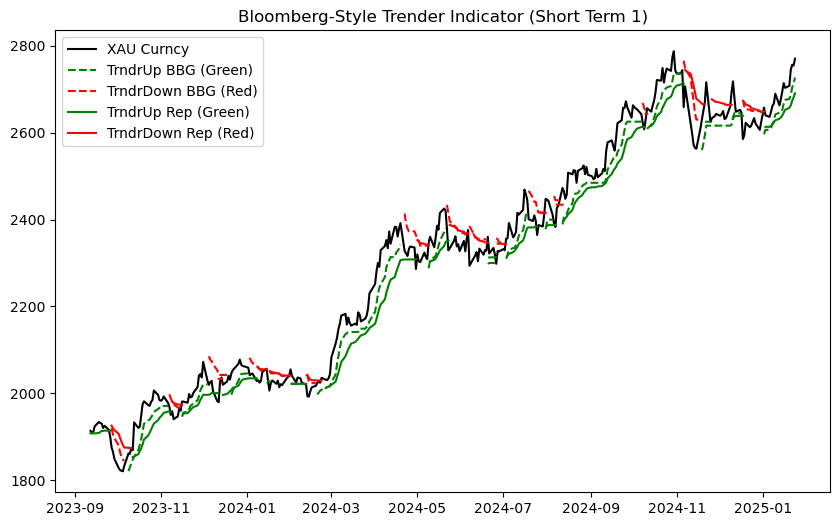

In [57]:
df = pd.read_excel("Gold_data.xlsx", sheet_name="Short_Term_1", index_col=0)
df.sort_index(inplace=True)
df = df[df.index.notnull()]


trender_lines = trender_bloomberg_style(df, period=14, sensitivity=1)


final_data = pd.merge(df, trender_lines, left_index=True, right_index=True,how = "left")

final_data.rename(columns = {'TrndrUp':'TrndrUp BBG' , 'TrndrDown': 'TrndrDown BBG',"TrenderUp":"TrndrUp Rep","TrenderDown":"TrndrDown Rep"},inplace = True)

plt.figure(figsize=(10,6))
plt.plot(final_data['Close'], label='XAU Curncy', color='black')
plt.plot(final_data['TrndrUp BBG'], label='TrndrUp BBG (Green)', color='green', linestyle='dashed')
plt.plot(final_data['TrndrDown BBG'], label='TrndrDown BBG (Red)', color='red', linestyle='dashed')
plt.plot(final_data['TrndrUp Rep'], label='TrndrUp Rep (Green)', color='green')
plt.plot(final_data['TrndrDown Rep'], label='TrndrDown Rep (Red)', color='red')
plt.legend()
plt.title("Bloomberg-Style Trender Indicator (Short Term 1)")
plt.show()

C:\Users\josel\AppData\Local\Temp\ipykernel_27940\1554620361.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  up_line[i] = max(up_base[i], up_line[i-1])
C:\Users\josel\AppData\Local\Temp\ipykernel_27940\1554620361.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  down_line[i] = min(down_base[i], down_line[i-1])


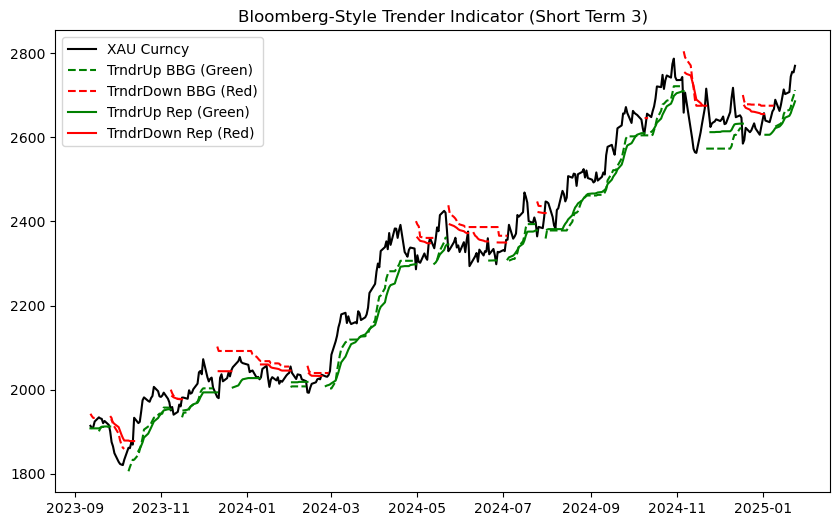

In [58]:
df = pd.read_excel("Gold_data.xlsx", sheet_name="Short_Term_3", index_col=0)
df.sort_index(inplace=True)
df = df[df.index.notnull()]


trender_lines = trender_bloomberg_style(df, period=14, sensitivity=3)


final_data = pd.merge(df, trender_lines, left_index=True, right_index=True,how = "left")

final_data.rename(columns = {'TrndrUp':'TrndrUp BBG' , 'TrndrDown': 'TrndrDown BBG',"TrenderUp":"TrndrUp Rep","TrenderDown":"TrndrDown Rep"},inplace = True)

plt.figure(figsize=(10,6))
plt.plot(final_data['Close'], label='XAU Curncy', color='black')
plt.plot(final_data['TrndrUp BBG'], label='TrndrUp BBG (Green)', color='green', linestyle='dashed')
plt.plot(final_data['TrndrDown BBG'], label='TrndrDown BBG (Red)', color='red', linestyle='dashed')
plt.plot(final_data['TrndrUp Rep'], label='TrndrUp Rep (Green)', color='green')
plt.plot(final_data['TrndrDown Rep'], label='TrndrDown Rep (Red)', color='red')
plt.legend()
plt.title("Bloomberg-Style Trender Indicator (Short Term 3)")
plt.show()

C:\Users\josel\AppData\Local\Temp\ipykernel_27940\1554620361.py:79: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  up_line[i] = max(up_base[i], up_line[i-1])
C:\Users\josel\AppData\Local\Temp\ipykernel_27940\1554620361.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  down_line[i] = min(down_base[i], down_line[i-1])


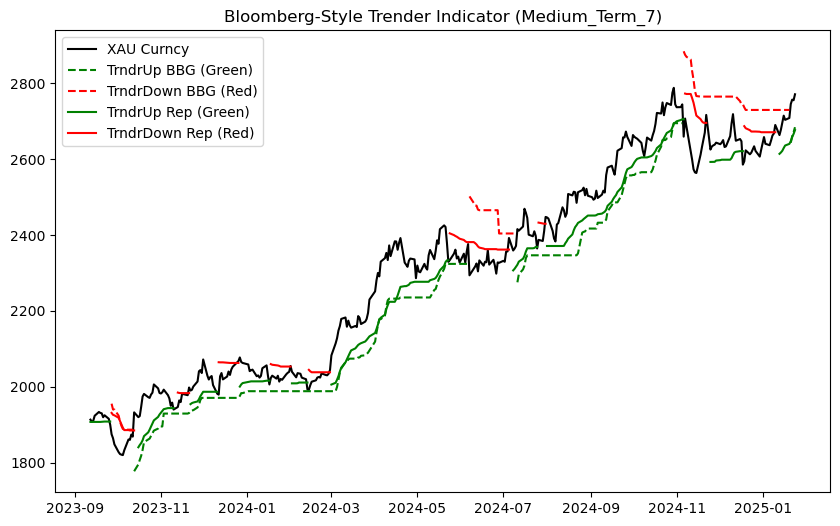

In [59]:
df = pd.read_excel("Gold_data.xlsx", sheet_name="Medium_Term_7", index_col=0)
df.sort_index(inplace=True)
df = df[df.index.notnull()]


trender_lines = trender_bloomberg_style(df, period=14, sensitivity=7)


final_data = pd.merge(df, trender_lines, left_index=True, right_index=True,how = "left")

final_data.rename(columns = {'TrndrUp':'TrndrUp BBG' , 'TrndrDown': 'TrndrDown BBG',"TrenderUp":"TrndrUp Rep","TrenderDown":"TrndrDown Rep"},inplace = True)

plt.figure(figsize=(10,6))
plt.plot(final_data['Close'], label='XAU Curncy', color='black')
plt.plot(final_data['TrndrUp BBG'], label='TrndrUp BBG (Green)', color='green', linestyle='dashed')
plt.plot(final_data['TrndrDown BBG'], label='TrndrDown BBG (Red)', color='red', linestyle='dashed')
plt.plot(final_data['TrndrUp Rep'], label='TrndrUp Rep (Green)', color='green')
plt.plot(final_data['TrndrDown Rep'], label='TrndrDown Rep (Red)', color='red')
plt.legend()
plt.title("Bloomberg-Style Trender Indicator (Medium_Term_7)")
plt.show()